In [1]:
import cv2
import numpy as np
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier as MLP
import os
import matplotlib.pyplot as plt
from scipy.cluster.vq import kmeans,vq


%pylab inline
pylab.rcParams['figure.figsize'] = (16, 6)

Populating the interactive namespace from numpy and matplotlib


In [27]:
class colorizer():
    def __init__(self,n_pixels=100,n_colors=16):
        self.n_pixels=n_pixels
        self.n_colors=n_colors
        self.n_samples=0
        self.centroids=None
        self.color_to_label_map = {}
        self.label_to_color_map = {}
        self.patch_size=6
    
    def load_dataset(self,folder='dataset'):
        l_ch=[]
        a_ch=[]
        b_ch=[]
        count=0
        
        for f in os.listdir(folder):
            if '.jpg' in f:
                l,a,b=cv2.split(cv2.cvtColor(cv2.imread(folder+'/'+f), cv2.COLOR_BGR2Lab))
                l_ch.append(l)
                a_ch.append(a)
                b_ch.append(b)
                count+=1
        self.n_samples=count
        return np.array(l_ch),np.array(a_ch),np.array(b_ch)

    
    
    def get_patch(self,im,pos):
        ps=int(self.patch_size/2)
        (x,y)=pos
        im=im[x-ps:x+ps,y-ps:y+ps]
        im=cv2.resize(im,(48,48))
        im=np.reshape(im,(48,48,1))
        #im=cv2.cvtColor(im,cv2.COLOR_GRAY2BGR)
        return im/255.
    
    def fit_kmeans(self,a,b):
        kma=[]
        kmb=[]
        for e in a:
            kma=np.concatenate([kma,e.flatten()])
        for e in b:
            kmb=np.concatenate([kmb,e.flatten()])
        kma.reshape((kma.shape[0],1))
        kmb.reshape((kmb.shape[0],1))
        pixel = np.squeeze(cv2.merge((kma,kmb)))
        self.centroids,_ = kmeans(pixel,self.n_colors)
        print('centroids',self.centroids)
        self.n_colors=len(self.centroids)
        self.color_to_label_map = {c:i for i,c in enumerate([tuple(i) for i in self.centroids])}
        self.label_to_color_map = dict(zip(self.color_to_label_map.values(),self.color_to_label_map.keys()))
        print('Kmeans fitted!')
        
    def quantize_kmeans(self,a,b):
        w,h = np.shape(a)
        pixel = np.reshape((cv2.merge((a,b))),(w * h,2))
        qnt,_ = vq(pixel,self.centroids)
        centers_idx = np.reshape(qnt,(w,h))
        clustered = self.centroids[centers_idx]
        a_quant = clustered[:,:,0]
        b_quant = clustered[:,:,1]
        return a_quant, b_quant
    
    def prepare_data(self):
        l,a,b=self.load_dataset(folder='open_country/train')
        kma=a.flatten()
        kmb=b.flatten()
        self.fit_kmeans(kma,kmb)
        X=[]
        Y=[]
        for i in range(self.n_samples):
            qa,qb=self.quantize_kmeans(a[i],b[i])
            w,h=l[i].shape
            for j in range(self.n_pixels):
                x=int(np.random.randint(w))
                y=int(np.random.randint(h))
                ps=int(self.patch_size/2)
                im2=cv2.copyMakeBorder(l[i],ps,ps,ps,ps,cv2.BORDER_WRAP)
                X.append(self.get_patch(im2, (x+ps,y+ps)))
                label=self.color_to_label_map[(qa[x,y], qb[x,y])]
                one_hot_class=np.zeros(self.n_colors)
                one_hot_class[label]=1
                Y.append(one_hot_class)
        X=np.array(X)
        Y=np.array(Y)
        return X,Y
    
    def train(self,X,Y):
        self.clf.fit(X,Y)
        print(self.clf.loss_)
        return self.clf
    
    def predict_im(self,impath):
        im=cv2.imread(impath,0)
        a=zeros_like(im)
        b=zeros_like(im)
        im2=cv2.copyMakeBorder(im,int(self.patch_size/2),cv2.BORDER_WRAP)
        for x in range(im.shape[0]):
            for y in range(im.shape[1]):
                patch=self.get_patch(im,(y+int(self.patch_size/2),x+int(self.patch_size/2)))
                #(ap,bp)=self.label_to_color_map[np.argmax(self.clf.predict_proba([X]))]
                a[x,y]=ap
                b[x,y]=bp
        return im,a,b

In [29]:
c=colorizer(n_colors=32,n_pixels=700)

In [30]:
X,Y=c.prepare_data()

('centroids', array([[ 122.5996263 ,  148.9976644 ],
       [ 133.70526624,   93.60356934],
       [ 123.15521482,  106.66433667],
       [ 128.26696255,  138.27054961],
       [ 119.92631873,  193.35166062],
       [ 119.81355201,   90.64683396],
       [ 119.25652712,  126.36913705],
       [ 119.63992537,  116.00577756],
       [ 128.72619048,  128.45759248],
       [ 127.26343699,  115.25142987],
       [ 125.60277834,   81.42943427],
       [ 110.44415204,  149.37809387],
       [ 126.77402759,   99.82375867],
       [ 134.22623545,  163.0887109 ],
       [ 109.21066969,  172.64605156],
       [ 129.37665194,  107.80128756],
       [ 141.53448276,  153.5095952 ],
       [ 118.90078906,  158.39784324],
       [ 118.47035381,  168.05404355],
       [ 124.08884617,  210.66757134],
       [ 126.08465736,  158.96364949],
       [ 115.81888488,  139.51601609],
       [ 121.26538444,  176.12705321],
       [ 109.98514826,  161.48794902],
       [ 114.58697794,  202.79609929],
       [ 10

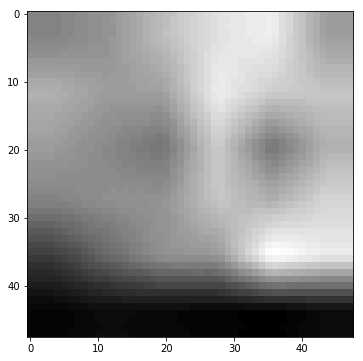

In [31]:
plt.imshow(np.reshape(X[3],(48,48)),cmap='gray')
plt.show()

In [24]:
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
import keras
import os
import cv2
import numpy as np
from keras.applications import vgg16

In [25]:
print(c.n_colors)
batch_size = 128
num_classes = c.n_colors
epochs = 20
img_rows, img_cols = (48,48)
input_shape = (img_rows, img_cols,1)

model=vgg16.VGG16(include_top=True,weights=None,classes=num_classes,input_shape=input_shape,pooling='max')
#last=initial_model.output

# # x = Flatten()(last)
# x = Dense(4096, activation='relu')(last)
# preds = Dense(num_classes, activation='softmax')(x)

#model=Model(initial_model.input,preds)

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])


30


In [26]:
model.fit(x=X,y=Y,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1)

Epoch 1/20
3000/3000 [==============================] - 14s - loss: 3.4594 - acc: 0.0620    
Epoch 2/20
3000/3000 [==============================] - 11s - loss: 3.3476 - acc: 0.0530    
Epoch 3/20
3000/3000 [==============================] - 12s - loss: 3.3150 - acc: 0.0617    
Epoch 4/20
3000/3000 [==============================] - 11s - loss: 3.3075 - acc: 0.0643    
Epoch 5/20
3000/3000 [==============================] - 11s - loss: 3.3012 - acc: 0.0600    
Epoch 6/20
3000/3000 [==============================] - 12s - loss: 3.3159 - acc: 0.0553    
Epoch 7/20
3000/3000 [==============================] - 12s - loss: 3.3000 - acc: 0.0670    
Epoch 8/20
3000/3000 [==============================] - 11s - loss: 3.2953 - acc: 0.0613    
Epoch 9/20
3000/3000 [==============================] - 12s - loss: 3.3113 - acc: 0.0640    
Epoch 10/20
3000/3000 [==============================] - 12s - loss: 3.3131 - acc: 0.0620    
Epoch 11/20
3000/3000 [==============================] - 13s - loss: 

KeyboardInterrupt: 

In [281]:

def predict_im(model,impath):
    im=cv2.imread(impath,0)
    
    ps=int(c.patch_size/2)
    print(im.shape)
    #im2=cv2.resize(im,None,fx=0.5,fy=0.5)
    a=zeros_like(im)
    b=zeros_like(im)
    im2=cv2.copyMakeBorder(im,ps,ps,ps,ps,cv2.BORDER_WRAP)
    
    print(im2.shape)
    for x in range(im.shape[0]):
        for y in range(im.shape[1]):
            patch=c.get_patch(im2,(x+ps,y+ps))
            (ap,bp)=c.label_to_color_map[np.argmax(model.predict(np.array([patch])))]
            a[x,y]=ap
            b[x,y]=bp
    #a=cv2.resize(a,None,fx=2,fy=2)
    #b=cv2.resize(b,None,fx=2,fy=2)
    a=cv2.medianBlur(a,5)
    b=cv2.medianBlur(b,5)
    return im,a,b


(100, 100)
(106, 106)


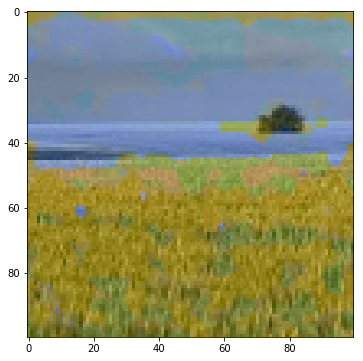

In [282]:

l,a,b=predict_im(model,'land358.jpg')
res=np.zeros((l.shape[0],l.shape[1],3),dtype=uint8)
res[:,:,0]=(l).astype(np.uint8)
res[:,:,1]=(a).astype(np.uint8)
res[:,:,2]=(b).astype(np.uint8)
colorized=cv2.cvtColor(res,cv2.COLOR_Lab2RGB)
plt.imshow(colorized)
plt.show()

In [286]:
c.n_colors

100

In [283]:
def predict_im(model,impath):
    im=cv2.imread(impath,0)
    a=zeros_like(im)
    b=zeros_like(im)
    a1=zeros_like(im)
    b1=zeros_like(im)
    ps=int(c.patch_size/2)
    m,n=im.shape
    im2=cv2.copyMakeBorder(im,ps,ps,ps,ps,cv2.BORDER_WRAP)
    label_costs = np.zeros((m,n,c.n_colors))
    g=get_edges(im)
    for x in range(im.shape[0]):
        for y in range(im.shape[1]):
            patch=c.get_patch(im2,(x+ps,y+ps))
            pred=model.predict(np.array([patch]))
            label_costs[y,x,:] = np.argmax(pred)
            (ap,bp)=c.label_to_color_map[np.argmax(pred)]
            a1[x,y] = ap
            b1[x,y] = bp
    output_labels = graphcut(label_costs,g)
    #print(output_labels)
    for i in range(m):
        for j in range(n):
            ax,bx= c.label_to_color_map[output_labels[i,j]]
            a[i,j] = ax
            b[i,j] = bx
    return im,a,b,a1,b1
    
def graphcut(label_costs,g, l=100):
    num_classes = c.n_colors
    pairwise_costs = np.zeros((num_classes, num_classes))
    for ii in range(num_classes):
        for jj in range(num_classes):
            c1 = np.array(c.label_to_color_map[ii])
            c2 = np.array(c.label_to_color_map[jj])
            pairwise_costs[ii,jj] = np.linalg.norm(c1-c2)

    label_costs_int32 = (100*label_costs).astype('int32')
    pairwise_costs_int32 = (l*pairwise_costs).astype('int32')
    vv_int32 = g.astype('int32')
    vh_int32 = g.astype('int32')
    new_labels = pygco.cut_simple_vh(label_costs_int32, pairwise_costs_int32, vv_int32, vh_int32, n_iter=10, algorithm='swap') 
    return new_labels

def get_edges(img, blur_width=3):
    img_blurred = cv2.GaussianBlur(img, (0, 0), blur_width)
    vh = cv2.Sobel(img_blurred, -1, 1, 0)
    vv = cv2.Sobel(img_blurred, -1, 0, 1)
    v = 0.5*vv + 0.5*vh
    return v

l,a,b,a1,b1=predict_im(model,'dataset_vic/test/vic2.jpg')
res=np.zeros((l.shape[0],l.shape[1],3),dtype=uint8)
res[:,:,0]=(l).astype(np.uint8)
res[:,:,1]=(a).astype(np.uint8)
res[:,:,2]=(b).astype(np.uint8)
res2=np.zeros((l.shape[0],l.shape[1],3),dtype=uint8)
res2[:,:,0]=(l).astype(np.uint8)
res2[:,:,1]=(a1).astype(np.uint8)
res2[:,:,2]=(b1).astype(np.uint8)
colorized=cv2.cvtColor(res,cv2.COLOR_Lab2RGB)
colorized2=cv2.cvtColor(res2,cv2.COLOR_Lab2RGB)
plt.imshow(colorized)
plt.show()
plt.imshow(colorized2)
plt.show()

KeyError: 93